In [5]:
import numpy as np

In [1]:
from PIL import Image
import rasterio
import os

folder_path = 'large_dataset/'

# find all images in the folder
images_names = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
images_ids = [int(image.split('large')[1].split('.')[0]) for image in images_names]
images_tif = [rasterio.open(folder_path + image) for image in images_names]

In [6]:
np_images = [np.moveaxis(image.read(), 0, -1) for image in images_tif]
nb_pixels = [image.shape[0] * image.shape[1] for image in np_images]

In [7]:
# keep ids of the images with more than 50000 pixels
keep_images_ids = [images_ids[i] for i in range(len(images_ids)) if nb_pixels[i] > 50000]
keep_np_images = [np_images[i] for i in range(len(np_images)) if nb_pixels[i] > 50000]

In [12]:

def gdal_get_pixel_of_longlat(fname, longlat, verbose=True):
    """
    returns the pixel coordinates for the points at longitude and latitude 
    (assuming a default altitude wrt the WGS84 reference ellipsoid) in the GeoTIFF image fname. 
    The CRS of the input GeoTIFF is determined from the metadata in the file.
    """
    # add vsicurl prefix if needed
    env = os.environ.copy()
    if fname.startswith(('http://', 'https://')):
        env['CPL_VSIL_CURL_ALLOWED_EXTENSIONS'] = fname[-3:]
        fname = '/vsicurl/{}'.format(fname)

    # form the query string for gdaltransform
    q = b''
    for coords in longlat:
        if len(coords) == 2:  # Only longitude and latitude provided
            coords = (*coords, 0)  # Append a default altitude of 0
        q = q + b'%f %f %f\n' % coords  # Unpack the tuple directly

    # call gdaltransform to convert longlat to pixel coordinates, -i does the inverse transformation
    cmdlist = ['gdaltransform', '-t_srs', "+proj=longlat", '-i', fname]
    if verbose:
        print('RUN: ' + ' '.join(cmdlist) + ' [long lat [alt] from stdin]')
    p = subprocess.Popen(cmdlist, env=env, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = p.communicate(q)
    if p.returncode != 0:
        raise RuntimeError("Command failed: %s\nError message: %s" % (' '.join(cmdlist), err.decode()))

    # parse the output from gdaltransform to get pixel coordinates
    listeout = [list(map(float, x.split())) for x in out.decode().splitlines()]
    # remove last coordinate of each point (which is the altitude)
    listeout = [x[:2] for x in listeout]
    return listeout

def get_bbox(polygon):
    x = [p[0] for p in polygon]
    y = [p[1] for p in polygon]
    return [min(x), min(y), max(x), max(y)]

In [11]:
from transformers import SamModel, SamProcessor
import torch
model = SamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
2024-03-06 11:20:47.051384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
import json
import subprocess

with open('landfills_openstreetmap.geojson') as f:
    data = json.load(f)

In [24]:
def generate_mask(i):
    image = keep_np_images[i]
    idx = keep_images_ids[i]
    
    fname = f'large_dataset/large{idx}.tif'
    polygon = data['features'][idx]['geometry']['coordinates'][0]
    polygon = gdal_get_pixel_of_longlat(fname, polygon)
    box = get_bbox(polygon)
    
    # image_embeddings = model.get_input_embeddings(inputs["pixel_values"])
    inputs = processor(image, input_boxes=[[box]], return_tensors="pt")
    # inputs.pop("pixel_values", None)
    # inputs.update({"image_embeddings": image_embeddings})
    with torch.no_grad():
        outputs = model(**inputs)
    masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
    # choose mask with the highest confidence
    mask = masks[0].cpu().numpy()
    mask = np.moveaxis(mask.squeeze(), 0, -1).astype(np.float32)
    return mask

In [41]:
mask = generate_mask(3)

RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2135.tif [long lat [alt] from stdin]


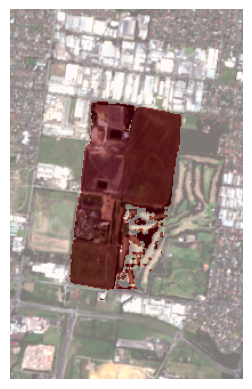

In [42]:
import matplotlib.pyplot as plt
# show the mask on the image
plt.imshow(keep_np_images[3])
plt.imshow(mask.max(axis=2), alpha=0.5, cmap="Reds")
plt.axis("off")
plt.show()

RUN: gdaltransform -t_srs +proj=longlat -i large_dataset/large2135.tif [long lat [alt] from stdin]


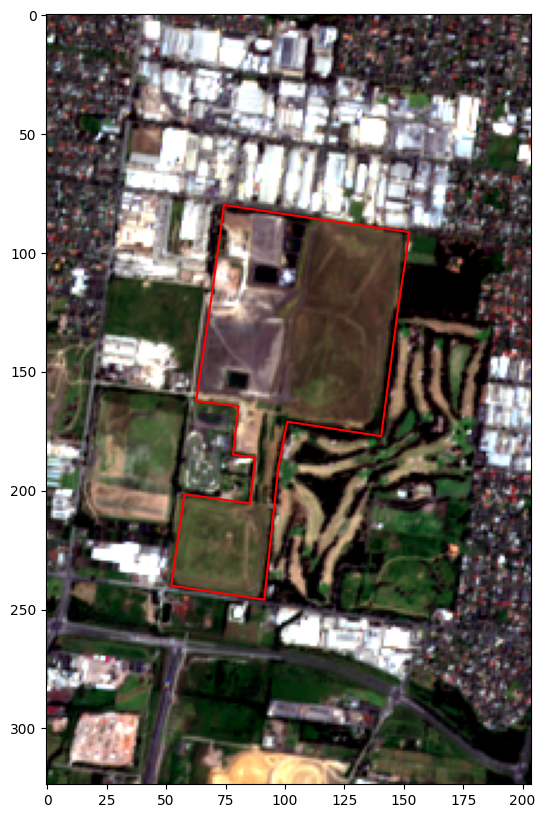

In [44]:
idx = keep_images_ids[3]
fname = f'large_dataset/large{idx}.tif'  
polygon = data['features'][idx]['geometry']['coordinates'][0]
# transform the polygon to pixel coordinates
polygon = gdal_get_pixel_of_longlat(fname, polygon)
RGB = rasterio.open(fname)
RGB = RGB.read()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(RGB.transpose(1, 2, 0))
ax.plot([x[0] for x in polygon], [x[1] for x in polygon], 'r-')